<a href="https://colab.research.google.com/github/Hyeok-Jun-Yoon/AI_Plus/blob/main/%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C_2%EC%A3%BC%EC%B0%A8_AI_2%EA%B8%B0_%EC%9C%A4%ED%98%81%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본과제: 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

In [1]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 1. [MYCODE] Last word prediction dataset 준비

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast # word embedding
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
#대소문자 구분 X :uncased

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

IMDB Dataset은 영화 리뷰와 그 리뷰의 감정을 표함한 데이터 셋


*   'text' : 영화 리뷰
*   'label' : 긍정 1 / 부정 0




In [4]:
print("IMDB Data Sample")
print(f"Text Review : {ds['train'][0]['text']}")
print(f"Label : {ds['train'][0]['label']}")

IMDB Data Sample
Text Review : I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scen

In [5]:
#[MYCODE] collate_fn 수정
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    # labels는 마지막 단어를 제외한 텍스트의 마지막 두 번째 토큰을 저장합니다.
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
    # texts는 입력 시퀀스에서 마지막 두 번째 토큰을 제외한 나머지 부분을 저장합니다.
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [7]:
# DataLoader에서 배치를 반복하면서 text와 labels를 출력합니다.
for batch_idx, (texts, labels) in enumerate(train_loader):
    # 배치의 텍스트와 라벨을 출력
    print(f"Batch {batch_idx + 1}:")
    print("Texts:", texts)
    print("Labels:", labels)

    # 첫 번째 배치만 확인하고 종료
    break


Batch 1:
Texts: tensor([[  101,  1037, 14726,  ...,  1012,  1012,  3052],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        [  101,  2053,  1011,  ...,  2013,  1037, 12090],
        ...,
        [  101,  2023,  3185,  ...,     0,     0,     0],
        [  101,  2026,  2155,  ...,     0,     0,     0],
        [  101,  2428,  2053,  ...,  2015,  2667,  2000]])
Labels: tensor([17904,   999,  2135,  1012,  1012,  1012,  1012,  1012,  1012,  1012,
        21294,  1997,   999,  1012,  1012,  1012,  1012,  2953,  1012,  1012,
         1012,  1012,   999,  1996,  1012,  1012,  1012,  1000,   999,   999,
          999,  1012,   999,  5530,  1012,  1012,  3178,  1007,  2143,   999,
         1012,   999,  1007,  2084,  1007,  1013,  1012,  1012,  1028,  1012,
         1012,  1012,   999,  1012,  1012,  1012,  1996,  1012,   999,   999,
         1012,  1012,  1012,  2265])


## Self-attention

In [8]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1) #0~1 사이의 확률분포로 나타내줌

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S) # 차원을 맞춰줌
    score = score / sqrt(self.d_model) #input 차원의 영향을 받지 않도록 제곱근 상수 연산 수행

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result #단어 갯수 만큼의 크기를 가지고 있음.

##TransformerLayer

In [9]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

## Positional encoding

In [10]:
import numpy as np

# 주기함수를 많이 사용

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [11]:
dataiter = iter(train_loader)
text, labels = next(dataiter) #data 파악을 위해
print(text.shape, labels.shape)

torch.Size([64, 398]) torch.Size([64])


## 2. [MYCODE]Loss function 및 classifier output 변경

토큰을 예측하는 분류 문제이므로 가장 일반적으로 사용되는 loss function인 Cross-Entropy Loss 사용


In [30]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size #어휘 크기, tokenizer에서 정의된 어휘 크기와 동일,입력테스트에서 사용할 수 있는 총 개수
    self.d_model = d_model # embedding vector 차원
    self.n_layers = n_layers
    self.dff = dff #Feed Forward Network 차원, 중간차원

    self.embedding = nn.Embedding(vocab_size, d_model) # 각 단어(토큰)를 d_model 차원의 벡터로 변환
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False) #requires_grad=False 위치 인코딩은 학습X, 고정된 값

    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size) #[MYCODE]토큰ID를 예측하는 문제에서 vocab_size 만큼의 클래스를 예측해야 됨.

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :] #3D 텐서로 변환,Attention계산에서 사용하도록 준비
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1] #{MYCODE} 마지막 단어의 벡터 선택
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

In [31]:
print(model)

TextClassifier(
  (embedding): Embedding(30522, 32)
  (layers): ModuleList(
    (0-1): 2 x TransformerLayer(
      (sa): SelfAttention(
        (wq): Linear(in_features=32, out_features=32, bias=True)
        (wk): Linear(in_features=32, out_features=32, bias=True)
        (wv): Linear(in_features=32, out_features=32, bias=True)
        (dense): Linear(in_features=32, out_features=32, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (ffn): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=30522, bias=True)
)


In [32]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() #[MYCODE] Cross-Entropy Loss 사용

optimizer = Adam(model.parameters(), lr=lr)

## 3. 학습 및 결과

In [34]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return (acc / cnt) * 100

In [35]:
n_epochs = 50
train_accs_list = []
test_accs_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long() #[MYCODE]]CrossEntropyLoss는 정수형 tensor 사용

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}") #[LOG] epoch 마다 손실합계 로그
  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}") #[LOG] epoch 마다 정확도 계산 출력
    test_accs_list.append(test_acc)
    train_accs_list.append(train_acc)

Epoch   0 | Train Loss: 1434.526288509369
=========> Train acc: 56.080 | Test acc: 56.348
Epoch   1 | Train Loss: 1077.6384642124176
=========> Train acc: 55.784 | Test acc: 56.168
Epoch   2 | Train Loss: 1050.2790577411652
=========> Train acc: 56.028 | Test acc: 56.280
Epoch   3 | Train Loss: 1035.612367272377
=========> Train acc: 56.028 | Test acc: 56.276
Epoch   4 | Train Loss: 1044.8065603971481
=========> Train acc: 55.780 | Test acc: 56.344
Epoch   5 | Train Loss: 1029.310674071312
=========> Train acc: 55.928 | Test acc: 56.152
Epoch   6 | Train Loss: 1024.7989566326141
=========> Train acc: 56.020 | Test acc: 56.284
Epoch   7 | Train Loss: 1022.7867702245712
=========> Train acc: 56.036 | Test acc: 56.252
Epoch   8 | Train Loss: 1019.6747084856033
=========> Train acc: 55.828 | Test acc: 56.176
Epoch   9 | Train Loss: 1021.6921792030334
=========> Train acc: 56.000 | Test acc: 56.264
Epoch  10 | Train Loss: 1018.0212659835815
=========> Train acc: 56.044 | Test acc: 56.280
Ep

In [36]:
import numpy as np
def plot_acc(train_accs_list, test_accs_list, label1='train', label2='test'):
  x = np.arange(len(train_accs_list))

  plt.plot(x, train_accs_list, label=label1)
  plt.plot(x, test_accs_list, label=label2)
  plt.legend()
  plt.show()

## [FEEDBAK] 정확도를 그래프로 나타냈을때 아래 와 같은데 맞게 학습을 한건지 잘못되었다면 어떤 부분을 수정을 해야 될까요?

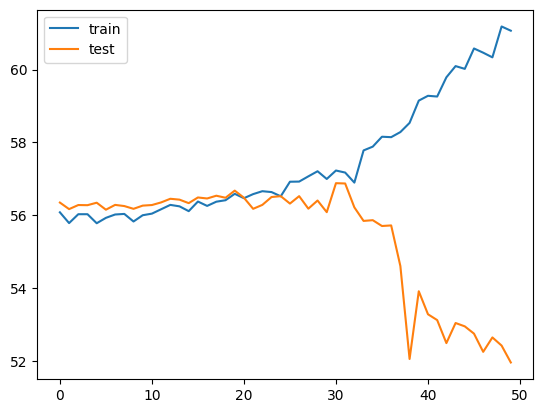

In [37]:
#[MY CODE] train과 test data에 대한 model의 정확도 plot
plot_acc(train_accs_list, test_accs_list, label1='train', label2='test')